In [10]:

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import scipy.io.wavfile as wavfile
import dsp_helpers as dsp
#%matplotlib widget
%matplotlib inline

In [11]:
# spring reverb impulse responses from:
# http://www.dubbhism.org/2008/10/free-download-60-classic-and-king-tubby.html
# resaved in audacity to convert sample to float32

ir_baseSample = 'kingtubby-fs2a.wav'
sample = 'untitled.wav'

# load impulse response from wav
ir_samplingRate, impulseResponse = wavfile.read(ir_baseSample, 'r')
impulseResponse = dsp.toMono(impulseResponse)
assert impulseResponse.ndim == 1

# lighten the computational load by excluding all 0 values from further calculation
impulseResponse = impulseResponse[impulseResponse != 0]

# load audio from wav
samplingRate, inputSignal = wavfile.read(sample, 'r')
inputSignal = dsp.toMono(inputSignal)
assert inputSignal.ndim == 1

# check if sampling rates match
#assert ir_samplingRate == samplingRate

# apply convolution, using the tubby impulse response. scipy.signal allows applying convolution in the frequency domain
# audio that has an effect applied to it is also called a "wet signal" (as opposed to a clean (dry) signal)
wetSignal = sig.fftconvolve(inputSignal, impulseResponse)
# normalize the signal (avoid distortion)
wetSignal = dsp.normalize(wetSignal)
print('Min: {0}, Max:{1}'.format(np.min(wetSignal), np.max(wetSignal)))

# the wet signal is longer than the original signal. the original signal needs to be padded to be able to combine them
assert len(wetSignal) > len((inputSignal))
# add some 0 to the end of the input signal to make up the difference
drySignal = np.concatenate((inputSignal, np.zeros(len(wetSignal) - len(inputSignal))))
assert len(wetSignal) == len(drySignal)
# normalize dry signal
drySignal = dsp.normalize(drySignal)

# combine dry signal with the wet signal. lower the magnitude of the wet signal by 6dB (approx. half the volume)
outSignal = drySignal + dsp.dB_to_magnitude(-6) * wetSignal
# normalize again to avoid clipping
outSignal = dsp.normalize(outSignal)
print('Min: {0}, Max:{1}'.format(np.min(outSignal), np.max(outSignal)))
wavfile.write('reverb_mix.wav', samplingRate, outSignal)
wavfile.write('reverb_wet.wav', samplingRate, wetSignal)


Min: -0.907843730190808, Max:0.99
Min: -0.99, Max:0.9229807942959414


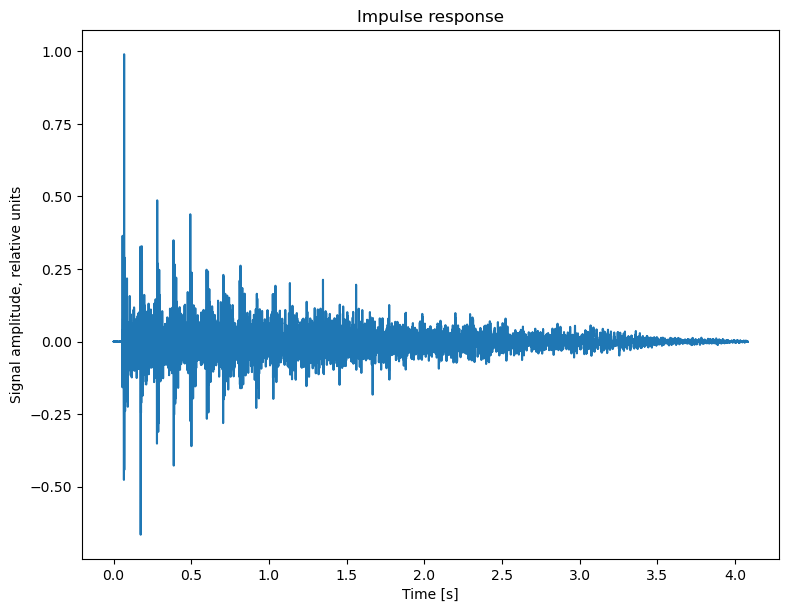

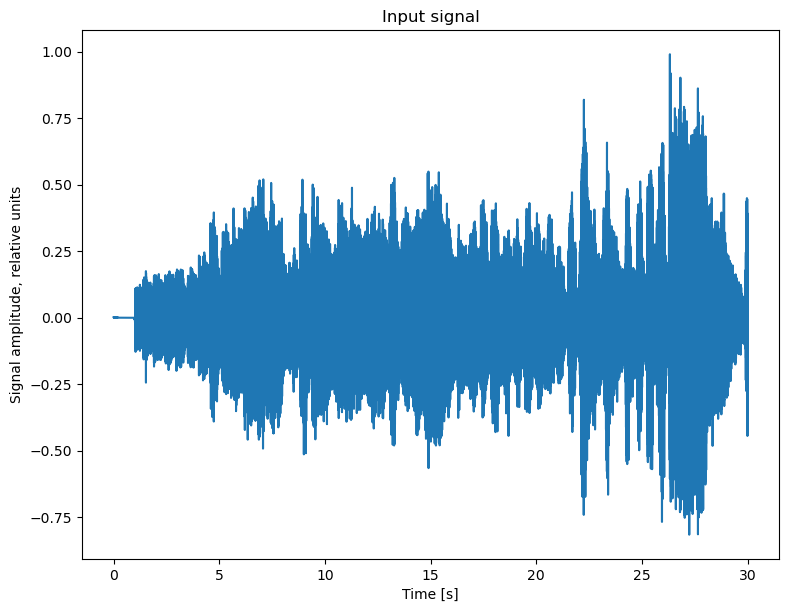

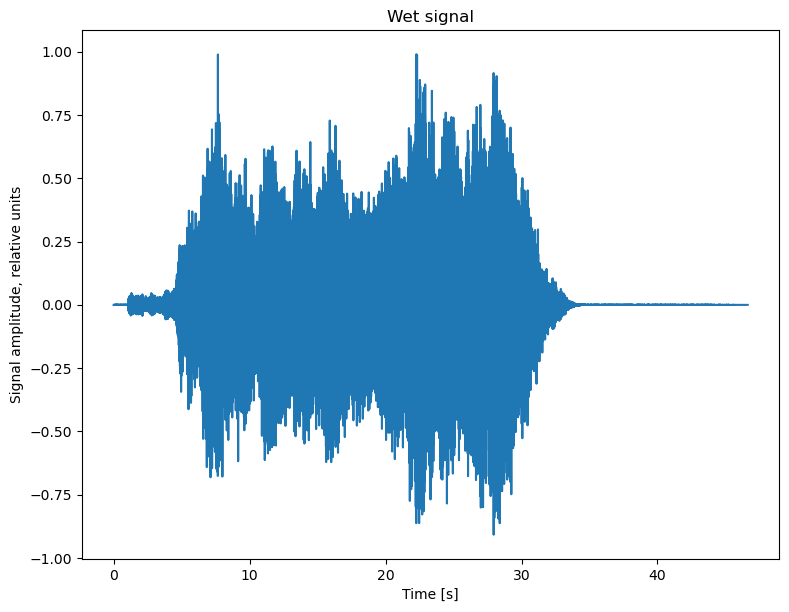

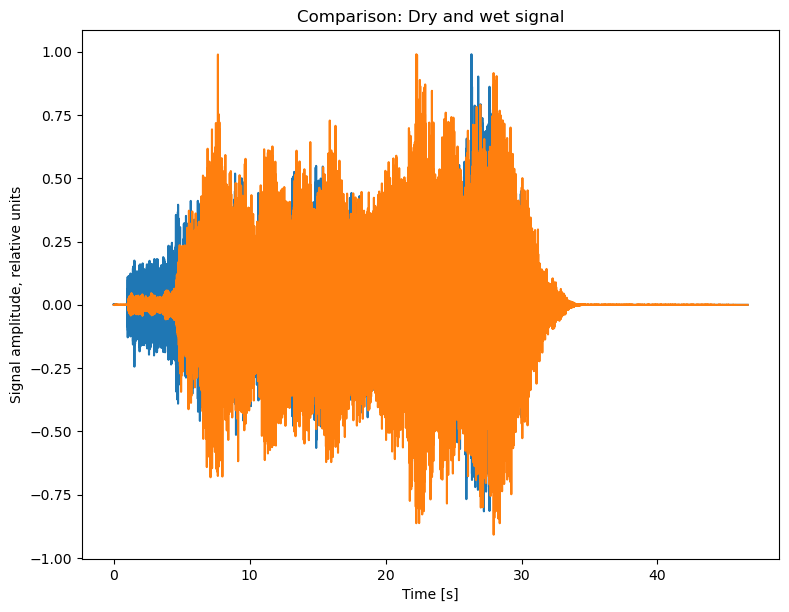

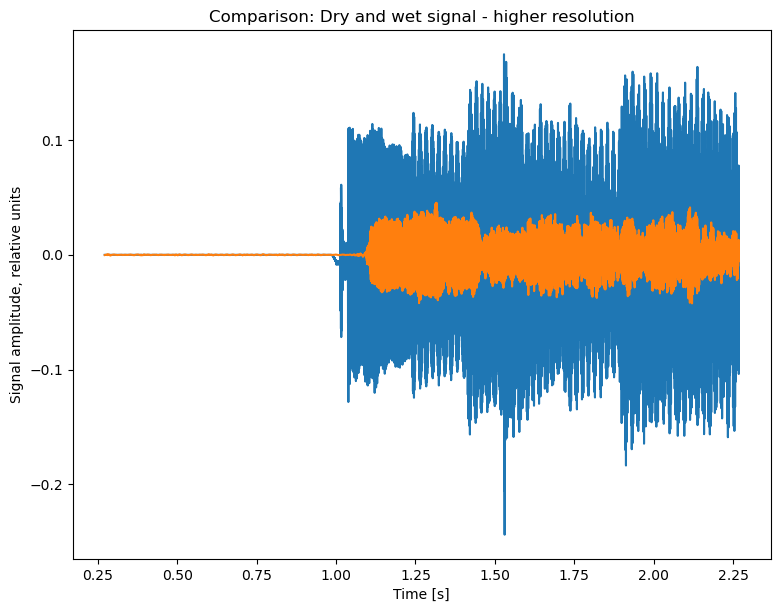

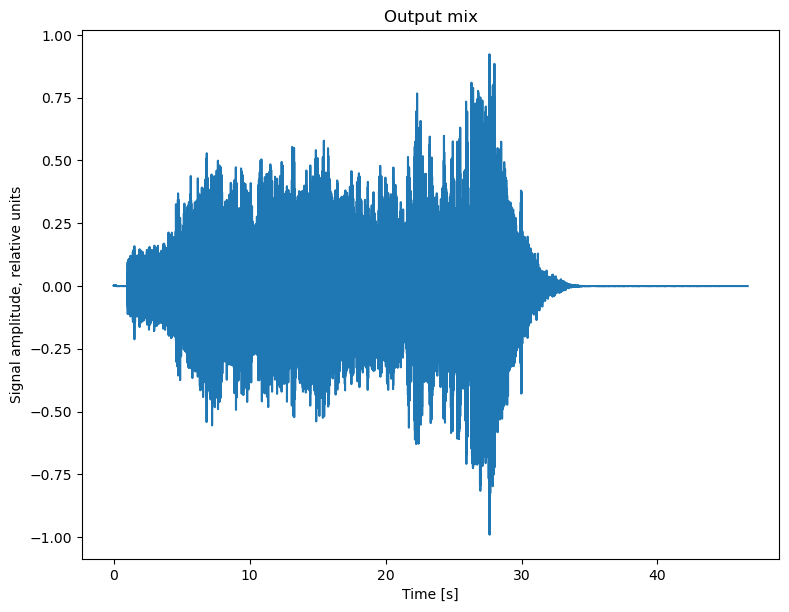

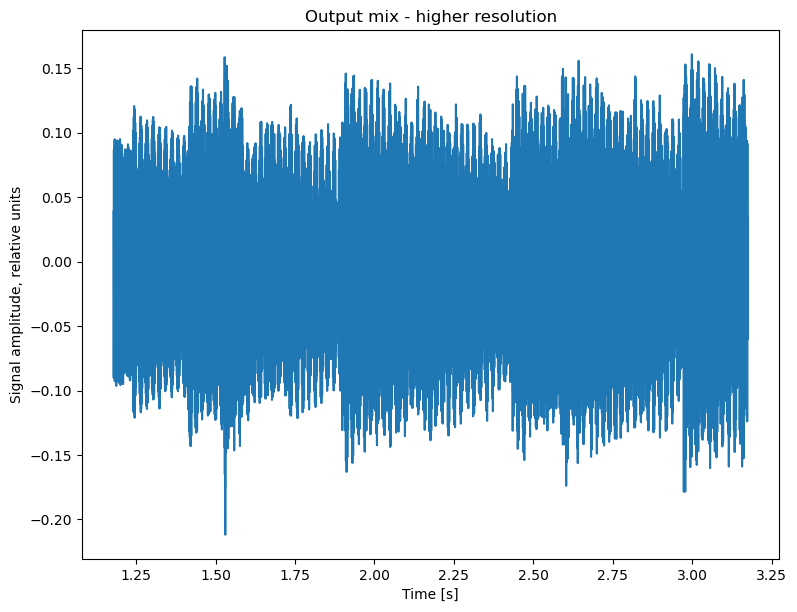

In [12]:
# plot signal against time
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (9, 7)
inputSignal = dsp.normalize(inputSignal)

plt.figure()
ax_convolution = dsp.plot(dsp.normalize(impulseResponse), samplingRate, start = 1, end = 90000)
ax_convolution.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Impulse response")
plt.show()

plt.figure()
ax_normalized = dsp.plot(dsp.normalize(inputSignal), samplingRate)
ax_normalized.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Input signal")
plt.show()

plt.figure()
ax_convolved = dsp.plot(wetSignal, samplingRate)
ax_convolved.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Wet signal")
plt.show()

plt.figure()
ax_normalized = dsp.plot(drySignal, samplingRate)
ax_combined = dsp.plot(wetSignal, samplingRate, ax_normalized)
ax_combined.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Comparison: Dry and wet signal")
plt.show()

plt.figure()
ax_normalized = dsp.plot(drySignal, samplingRate, start = 6000, end = 50000)
ax_combined = dsp.plot(wetSignal, samplingRate, ax_normalized, start = 6000, end = 50000)
ax_combined.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Comparison: Dry and wet signal - higher resolution")
plt.show()

plt.figure()
ax_convolved = dsp.plot(outSignal, samplingRate)
ax_convolved.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Output mix")
plt.show()

plt.figure()
ax_convolved = dsp.plot(outSignal, samplingRate, start = 26000, end = 70000)
ax_convolved.set(xlabel = "Time [s]", ylabel = "Signal amplitude, relative units", title = "Output mix - higher resolution")
plt.show()

In [13]:
# plotting the frequency content

# inverse of the sampling rate
sampleSpacing = 1.0 / samplingRate

input_fftSpectrum = np.fft.rfft(inputSignal)
output_fftSpectrum = np.fft.rfft(outSignal)
ir_fftSpectrum = np.fft.rfft(impulseResponse)
input_freq = np.fft.rfftfreq(inputSignal.size, sampleSpacing) 
output_freq = np.fft.rfftfreq(outSignal.size, sampleSpacing)
ir_freq = np.fft.rfftfreq(impulseResponse.size, sampleSpacing)

input_fftSpectrum

array([-4.14945122e+03 +0.j        ,  1.40155207e+02-30.30919583j,
        1.44472646e+02-57.18548708j, ...,  2.38422755e+00 -0.27421744j,
       -2.73297951e-01 -2.58021709j, -4.62412735e-01 +0.j        ])

In [14]:
# FFT is complex, whereas the imaginary part is used to calculate the signal phase. To simplify, use only real values of the transform
input_fftSpectrum_abs = np.abs(input_fftSpectrum)
output_fftSpectrum_abs = np.abs(output_fftSpectrum)
ir_fftSpectrum_abs = np.abs(ir_fftSpectrum)

input_fftSpectrum_abs

array([4.14945122e+03, 1.43395012e+02, 1.55378652e+02, ...,
       2.39994505e+00, 2.59465065e+00, 4.62412735e-01])

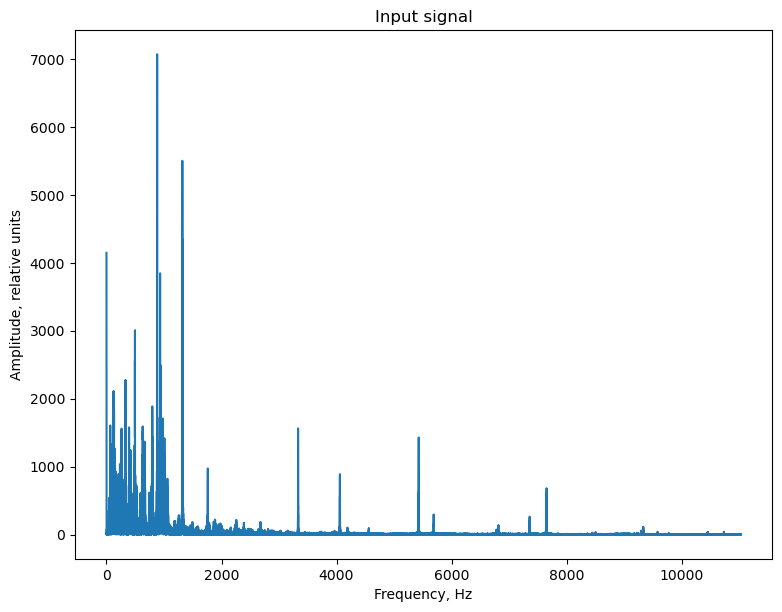

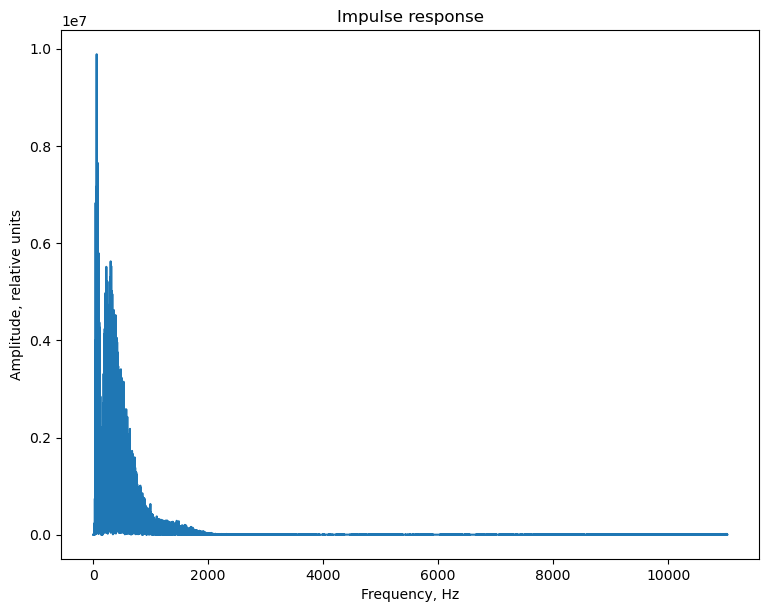

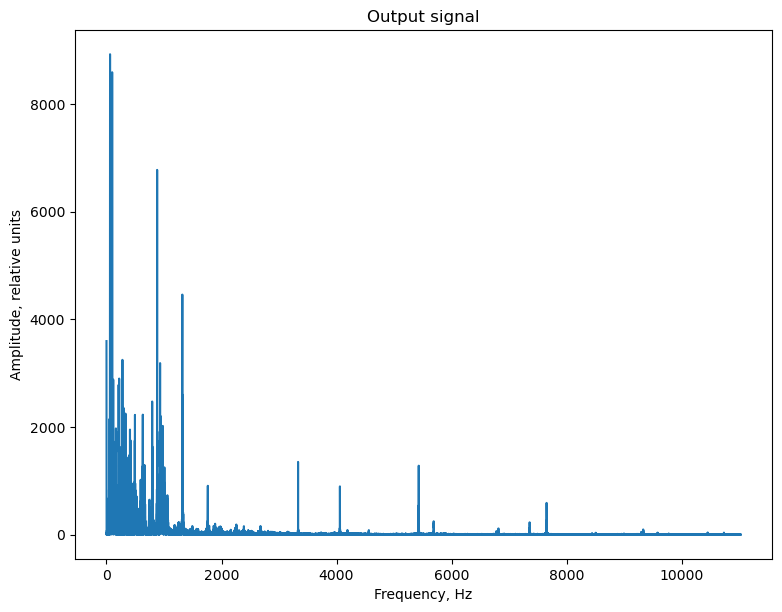

In [15]:
plt.plot(input_freq, input_fftSpectrum_abs)
plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude, relative units")
plt.title("Input signal")
plt.show()

plt.plot(ir_freq, ir_fftSpectrum_abs)
plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude, relative units")
plt.title("Impulse response")
plt.show()

plt.plot(output_freq, output_fftSpectrum_abs)
plt.xlabel("Frequency, Hz")
plt.ylabel("Amplitude, relative units")
plt.title("Output signal")
plt.show()

Text(0, 0.5, 'Frequency [Hz]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
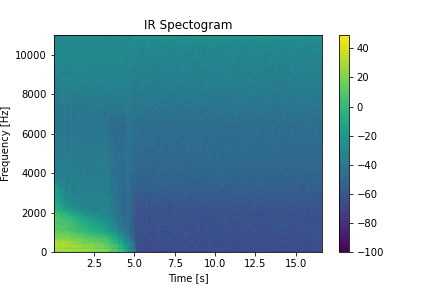

In [16]:
%matplotlib widget

plt.specgram(impulseResponse, Fs = samplingRate, NFFT = 512, noverlap = 500, vmin = -100)
plt.colorbar()
plt.title('IR Spectogram')
plt.xlabel('Time [s]')
plt.ylabel("Frequency [Hz]")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
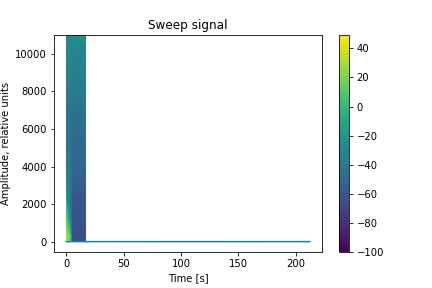

In [17]:
echoPeriod = 55e-3
sweep_startFreq = 200
sweep_endFreq = 3e3
numEchoes = 30
echoAmplitude = dsp.dB_to_magnitude(-1)
# must be negative
gain = -2

echoPeriodInSamples = round(echoPeriod * samplingRate)

ir_sampleLength = echoPeriodInSamples * numEchoes
ir_synth = np.zeros(ir_sampleLength)

# 
sweep_freqEnvelope = np.linspace (sweep_startFreq, sweep_endFreq, echoPeriodInSamples)

### =============================================denkfehler? (see: Introduction to digital audio processing - p 16)
# cumulative sum in discrete time == integral in continuous time
# allows converting phase to frequency
sweep_signal = np.sin(2 * np.pi * np.cumsum((sweep_freqEnvelope) / samplingRate))

plt.plot(sweep_signal[1000:12000])
plt.ylabel("Amplitude, relative units")
plt.title("Sweep signal")
plt.show()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
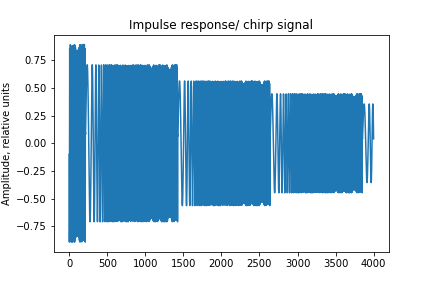

In [18]:

# get start-sample of each echo by creating an array with the echo indexes and multiply each index with the sample count
echoStartSamples = np.arange(numEchoes) * echoPeriodInSamples
# iterate through the number of echoes times the period of each echo
for sample in echoStartSamples:
    # create an array with the length of the sweep signal at each echoStart index
    sweep_array = sample + np.arange(len(sweep_signal))
    # add the sweep signal at chosen amplitude
    ir_synth[sweep_array] += sweep_signal * echoAmplitude
    # lower the amplitude for the next iteration
    echoAmplitude *= dsp.dB_to_magnitude(gain)

#%matplotlib widget
plt.figure()
plt.plot(ir_synth[1000:5000])
plt.ylabel("Amplitude, relative units")
plt.title("Impulse response/ chirp signal")
plt.show()

Text(0.5, 1.0, 'Impulse response/ chirp signal, higher resolution')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
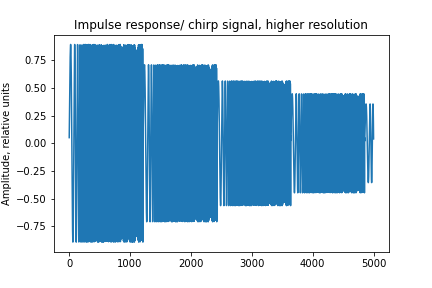

In [19]:
plt.figure()
plt.plot(ir_synth[0:5000])
plt.ylabel("Amplitude, relative units")
plt.title("Impulse response/ chirp signal, higher resolution")

In [20]:
ir_synth = dsp.normalize(ir_synth)
wavfile.write("synth_ir.wav", samplingRate, ir_synth)

# convolve dry sample with impulse response
ir_wetSignal = sig.fftconvolve(inputSignal, ir_synth)
ir_synth.shape
inputSignal.shape

(661500,)

In [21]:

drySignal = np.concatenate((inputSignal, np.zeros(len(ir_wetSignal) - len(inputSignal))))
synth_mix = drySignal + ir_wetSignal * dsp.dB_to_magnitude(-6)
synth_mix = dsp.normalize(synth_mix)
wavfile.write("synth_mix.wav", samplingRate, synth_mix)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
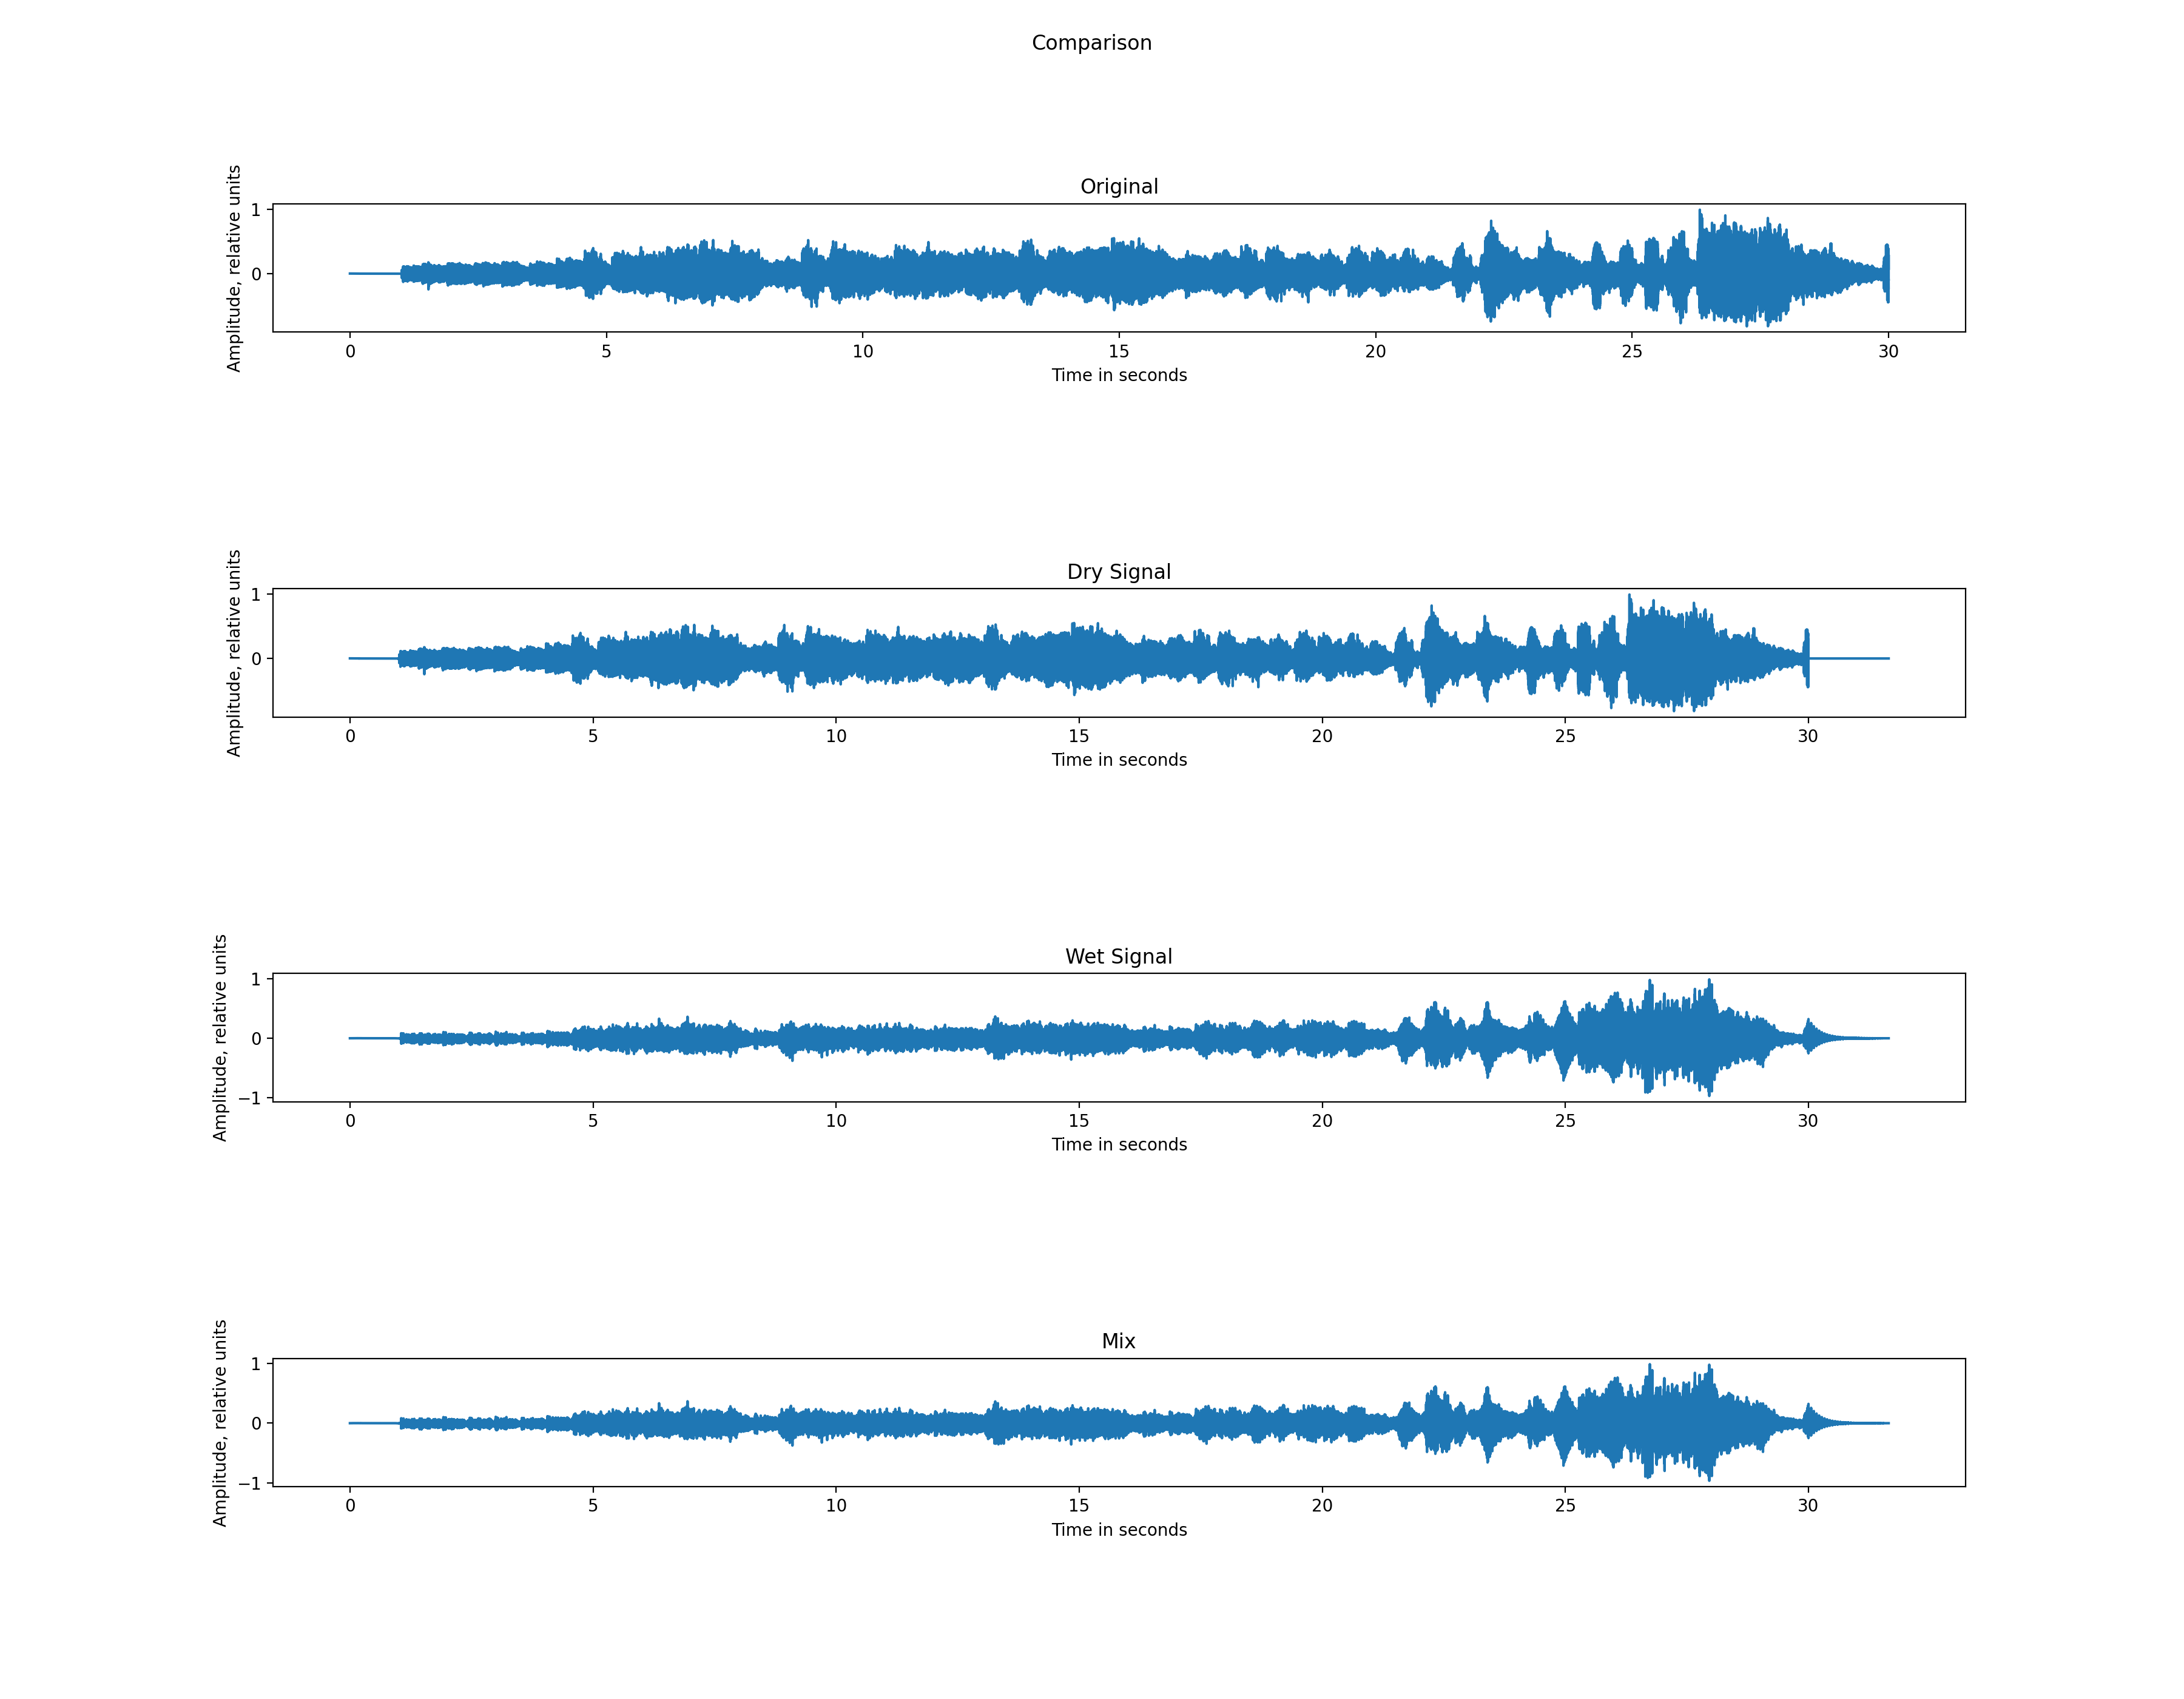

In [22]:
# TODO: shared ylabel for all subplots
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (18, 14)

plt.figure()
plt.suptitle('Comparison')
plt.subplot(4, 1, 1)
plt.title("Original")
plt.plot(dsp.time(inputSignal, samplingRate), inputSignal)
plt.ylabel("Amplitude, relative units")
plt.xlabel('Time in seconds')

plt.subplot(4, 1, 2)
plt.ylabel("Amplitude, relative units")
plt.xlabel('Time in seconds')
plt.plot(dsp.time(drySignal, samplingRate), drySignal)
plt.title("Dry Signal")

plt.subplot(4, 1, 3)
plt.ylabel("Amplitude, relative units")
plt.xlabel('Time in seconds')
plt.plot(dsp.time(ir_wetSignal, samplingRate), dsp.normalize(ir_wetSignal))
plt.title("Wet Signal")

plt.subplot(4, 1, 4)
plt.ylabel("Amplitude, relative units")
plt.xlabel('Time in seconds')
plt.plot(dsp.time(synth_mix, samplingRate), synth_mix)
plt.title("Mix")

plt.subplots_adjust(hspace = 2)

#ylim setzen